# Valorant Project: Machine Learning

<hr>  
  
### Topic

Can stats such as headshot percentage, accuracy, kda, kast, acs, ability usage, damage delta, eco score, and win rate be used as an indicator of rank?

<hr>

### Data Collection

##### Calculating KAST:




KAST % = KAST rounds / total rounds  
> Check each round if the player KAST  
>> For Kill check for the round, find the player and check if kills is > 0   
  
>> For Assist check for the round, find the player and check if they were 'assistants' in the kill events; if empty then no assist  
  
>> For Survived check for the round, iterate through all kill events and identify if the player was a victim; if did not appear, then survived  
>>> Up for improvement on whether surviving means losing the round is still good (save weapon but could be achieved by lurking and hiding)  
  
>> For Traded check for the round, check on whether the player was a victim; if so, then if the killer is a victim in the next 5 seconds, then it is a trade  
  
>>> need to track time of death of the player, and then time of death of killer
>>> need puuid to match when iterating through player list on rounds dict

#### Code

In [1]:
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


runs = []
with open("C:\\Users\\Binaryxx Sune\\Documents\\Programming\\personal_projects\\data\\competitive_data.pkl", "rb") as comp_data_file:
    try:
        while True:
                runs.append(pkl.load(comp_data_file))
    except:
        pass
matches = sum(runs, [])

agent = []
rank = []
outcome = []
ability_usage_avg = []
acs = []
kda = []
hs = []
dd = []
kast = []

for match in matches:
    # get the number of rounds played
    rounds_played = match["metadata"]["rounds_played"]

    # loop through each player in the match to collect their data
    for player in match["players"]["all_players"]:
        # get agent selected by each player and their rank; agent played may be a determinant of stats (duelists have higher acs)
        agent.append(player["character"])
        rank.append(player["currenttier"])
        # get match outcome of each player to determine win rate
        player_team = player["team"].lower()
        outcome.append(match["teams"][player_team]["has_won"])
        # get player average ability usage
        abilities_used = []
        for usage in player["ability_casts"].values():
            if usage:
                abilities_used.append(usage)
            else:
                abilities_used.append(0)
        ability_usage_avg.append(sum(abilities_used) / rounds_played)
        # get player average combat score
        acs.append(player["stats"]["score"] / rounds_played)
        # get player kda; common methods of calculating kda makes it so dying once doesnt affect kda; counting lives would be an accurate stat but to follow standards, deaths will be counted; no deaths in a match is an outlier (when people surrender)
        if player["stats"]["deaths"] != 0:
            kda.append((player["stats"]["kills"] + player["stats"]["assists"]) / player["stats"]["deaths"])
        else:
            kda.append((player["stats"]["kills"] + player["stats"]["assists"]) / (player["stats"]["deaths"]+1))
        # get player headshot rate
        if (player["stats"]["headshots"] != 0) and (player["stats"]["bodyshots"] != 0) and (player["stats"]["legshots"] != 0):
            hs.append(player["stats"]["headshots"] / (player["stats"]["headshots"] + player["stats"]["bodyshots"] + player["stats"]["legshots"]))
        else:
            hs.append(0)
        # get player damage delta
        dd.append((player["damage_made"] - player["damage_received"]) / rounds_played)
        # get player kast
        kast_count = []
        # loop through each round to get the neccesary info to determine if kast criteria is met
        # TODO: employ a way to cutoff the loop if one of the criteria has been met for kast so unnecesary work is avoided
        for rounds in match["rounds"]:
            # loop through each player per round
            dead_check = []
            for player_round in rounds["player_stats"]:
                # need to reidentify the same player
                if player_round["player_puuid"] == player["puuid"]:
                    # check if the player got at least a kill that round
                    if player_round["kills"] != 0:
                        killed = True
                    else:
                        killed = False
                # loop through each kill event if there is one
                if player_round["kill_events"]:
                    for kill in player_round["kill_events"]:
                        # check through the kills that occured if the player got at least an assist in one of those
                        for assistant in kill["assistants"]:
                            if assistant["assistant_puuid"] == player["puuid"]:
                                assisted = True
                            else:
                                assisted = False
                        # check if the player survived; was not a victim in any kills
                        if kill["victim_puuid"] == player["puuid"]:
                            dead_check.append(True)
                            # if did not survive, keep track of killer for traded
                            killer = kill["killer_puuid"]
                            killer_time = kill["kill_time_in_round"]
                            # set traded as False so that it can only be set as True if it meets the criteria of the killer dying within 5 seconds
                            traded = False
                            # loop through the players to check whether the killer dies within a certain time frame
                            for player_round_2 in rounds["player_stats"]:
                                if player_round_2["kill_events"]:
                                    for kill_2 in player_round_2["kill_events"]:
                                        # check if the killer dies within 5 seconds from player death
                                        if kill_2["victim_puuid"] == killer:
                                            if kill_2["kill_time_in_round"] <= (killer_time + 5000):
                                                traded = True               
                        else:
                            traded = False
            if dead_check:
                survived = False
            else:
                survived = True
                
        
            if (killed == True) or (assisted == True) or (survived == True) or (traded == True): 
                kast_count.append(1)
            else:
                kast_count.append(0)

        kast.append(sum(kast_count) / rounds_played)

data_dict = {"agent": agent, "rank": rank, "outcome": outcome, "ability_usage_avg": ability_usage_avg, "acs": acs, "kda": kda, "hs": hs, "dd": dd, "kast": kast}

val_data = pd.DataFrame(data_dict)
val_data = val_data[val_data["rank"] != 0] # filter out non calibrated records

<hr>

### Data Review

#### Quick Stat Summary

In [2]:
val_data

,agent,rank,outcome,ability_usage_avg,acs,kda,hs,dd,kast
0,Reyna,14,True,2.857143,369.785714,3.428571,0.169231,121.571429,0.785714
1,Phoenix,14,True,2.142857,323.857143,2.714286,0.294118,105.428571,0.857143
2,Fade,13,True,2.928571,132.000000,1.666667,0.000000,-56.500000,0.857143
3,Killjoy,12,False,2.500000,202.857143,0.714286,0.169811,-18.928571,0.500000
4,Jett,15,False,2.357143,201.214286,0.785714,0.000000,-29.785714,0.500000
...,...,...,...,...,...,...,...,...,...
1415,Fade,14,True,3.437500,304.875000,3.714286,0.277778,112.625000,0.812500
1416,Reyna,16,True,1.937500,288.437500,2.333333,0.172414,75.250000,0.750000
1417,Viper,14,False,0.625000,139.437500,0.562500,0.000000,-77.687500,0.375000
1418,Reyna,13,False,1.500000,261.125000,1.214286,0.441176,-22.250000,0.625000


In [3]:
val_data.describe()

,rank,ability_usage_avg,acs,kda,hs,dd,kast
count,1322.000000,1322.000000,1322.000000,1322.000000,1322.000000,1322.000000,1322.000000
mean,12.339637,2.074087,212.821152,1.468192,0.154594,0.086936,0.620584
std,3.683392,0.737349,74.037970,0.698319,0.092661,50.629195,0.137370
min,4.000000,0.000000,0.000000,0.000000,0.000000,-123.590909,0.142857
25%,10.000000,1.563179,159.916667,1.000000,0.092335,-35.437500,0.526316
50%,12.000000,2.038462,203.623737,1.310096,0.147541,-5.964286,0.619048
75%,15.000000,2.521739,258.822917,1.775641,0.211285,30.822917,0.714286
max,22.000000,4.875000,466.800000,5.750000,0.630435,164.090909,1.000000


#### Histogram Function

In [4]:
def give_hist(x_var):
    sns.set(rc = {"figure.figsize": (16, 8), 'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})

    sns.histplot(data = val_data, x = x_var)
    plt.show()

#### Agent

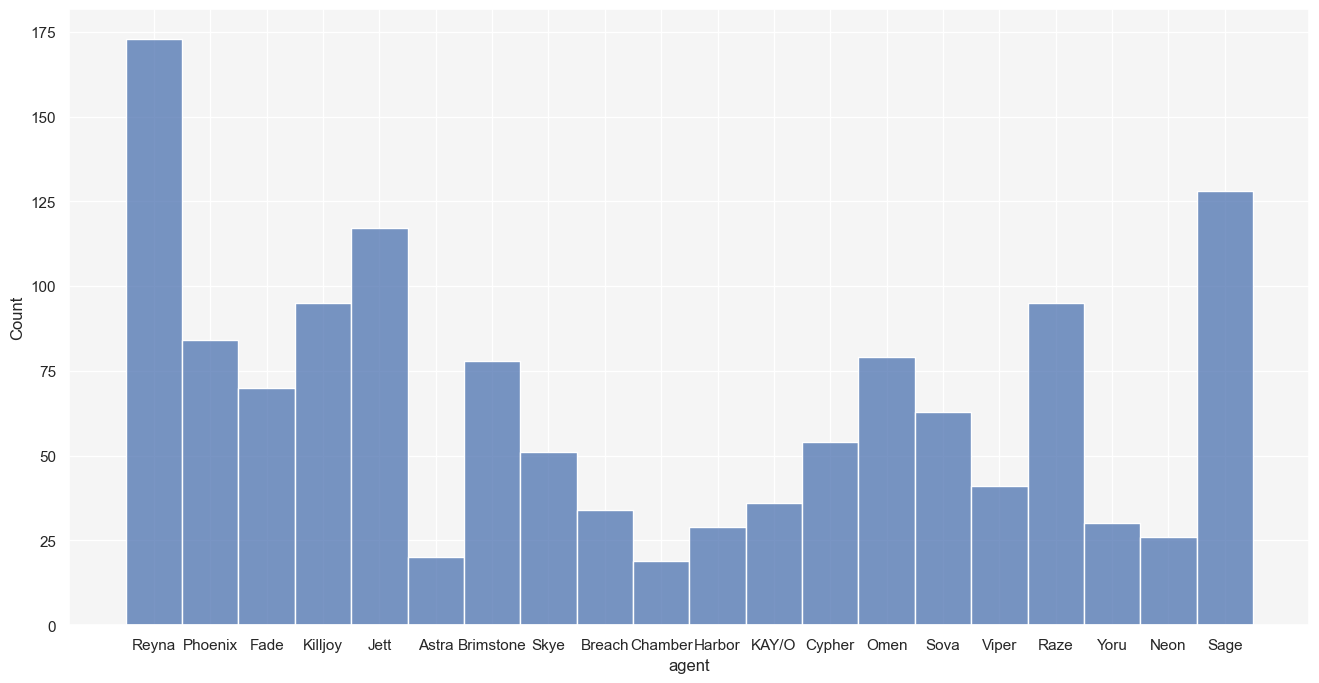

In [5]:
give_hist("agent")

#### Win

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


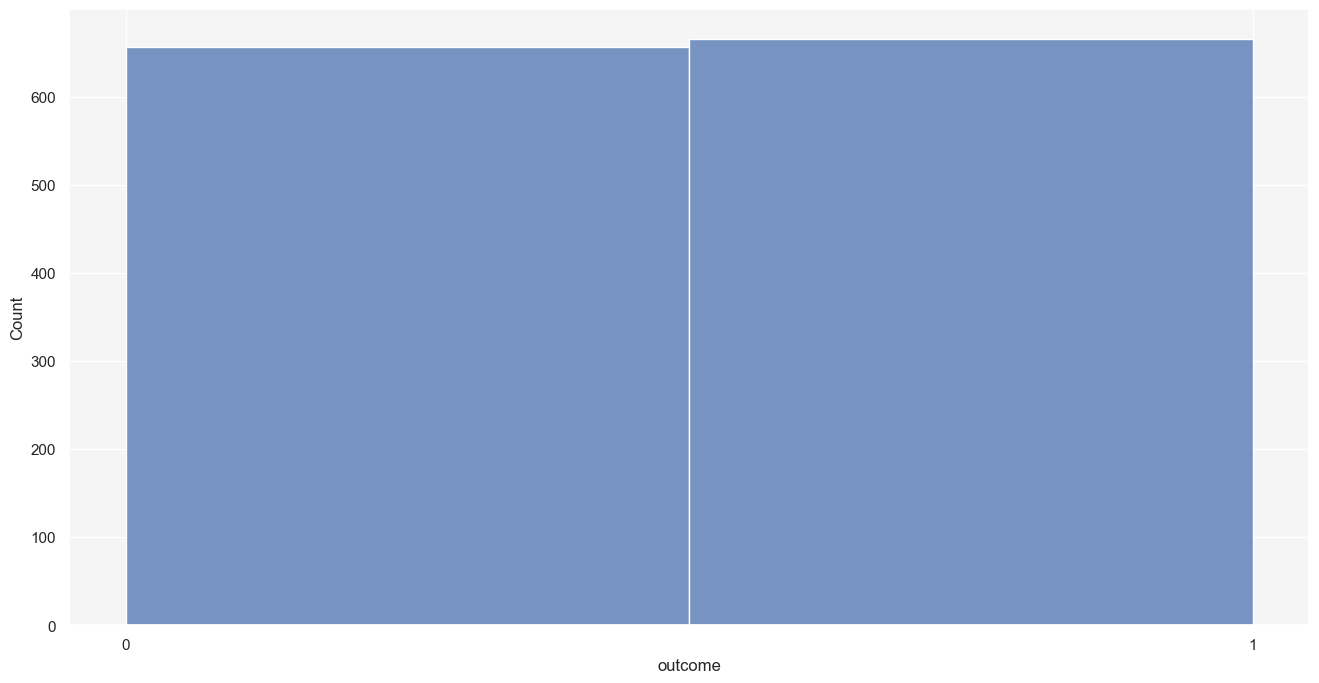

In [6]:
# Custom plot since outcome is boolean
sns.set(rc = {"figure.figsize": (16, 8), 'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})

sns.histplot(data = val_data, x = "outcome", bins = 2)

plt.xticks([0,1])
plt.show()

# More wins than losses; uncalibrateds are usually losses since that's the only one filtered out

#### Ability Use

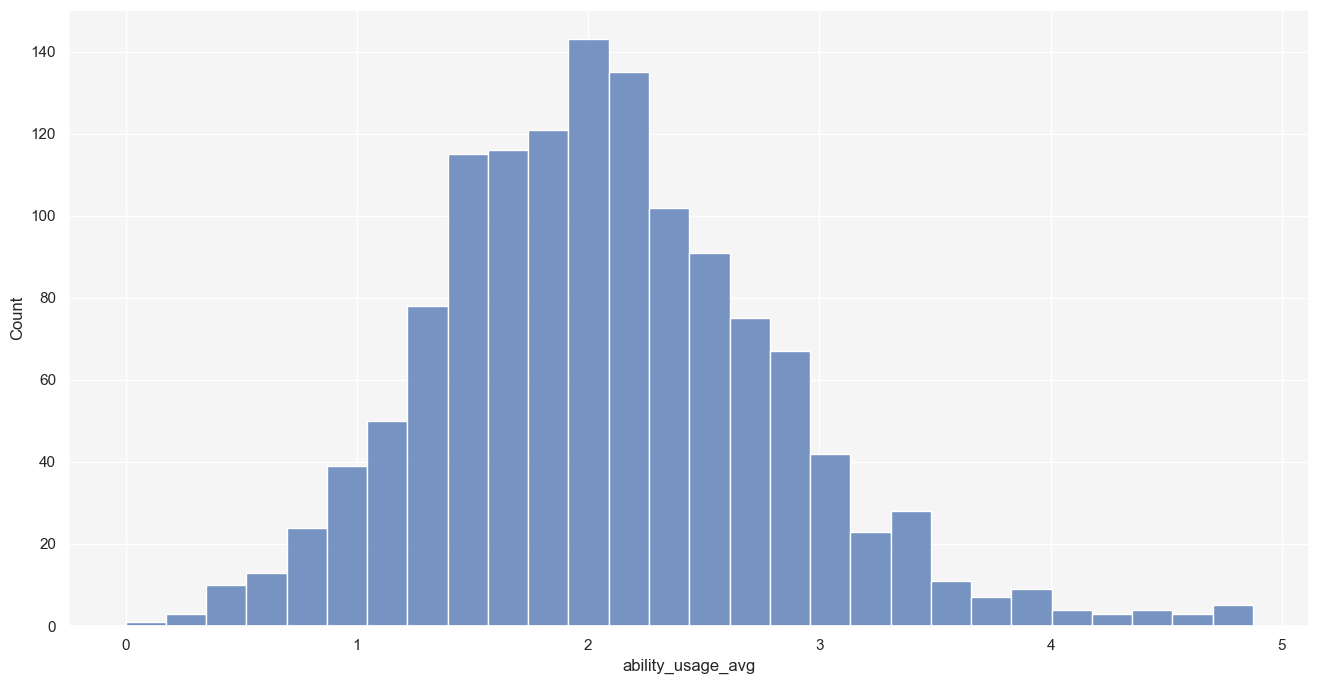

In [7]:
give_hist("ability_usage_avg")

#### Average Combat Score

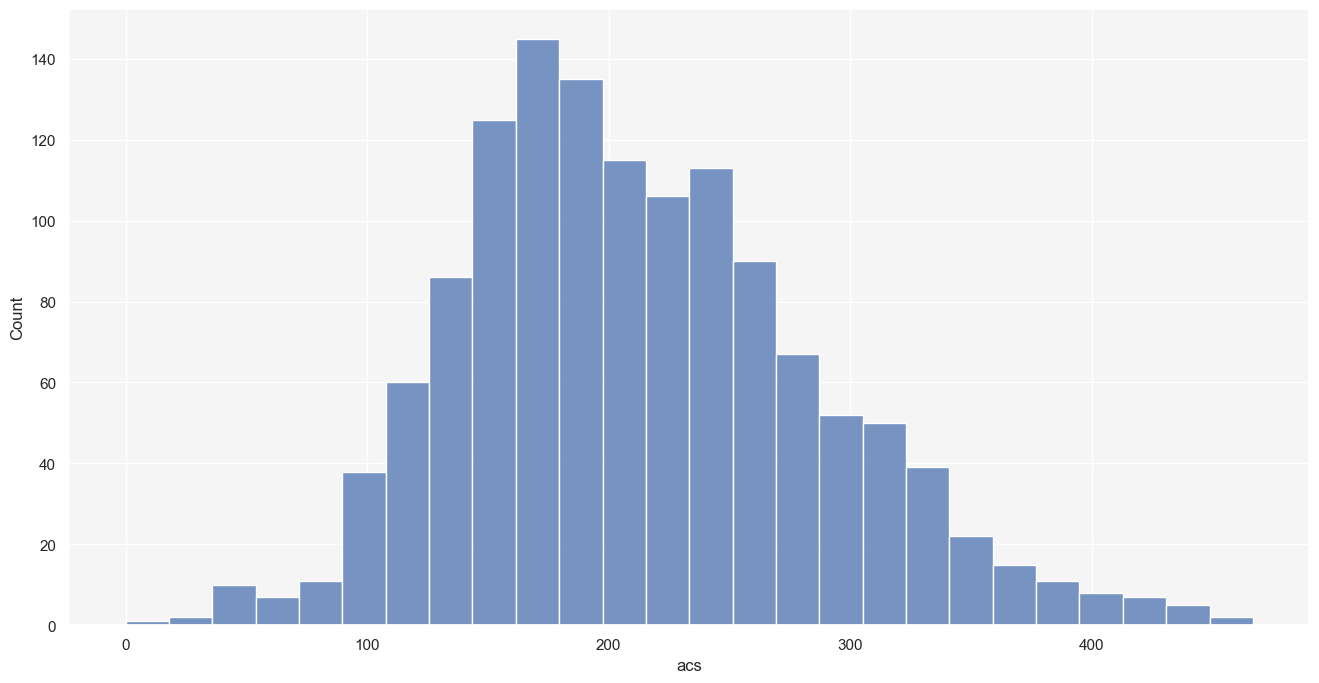

In [8]:
give_hist("acs")

#### Kills / Death / Assists

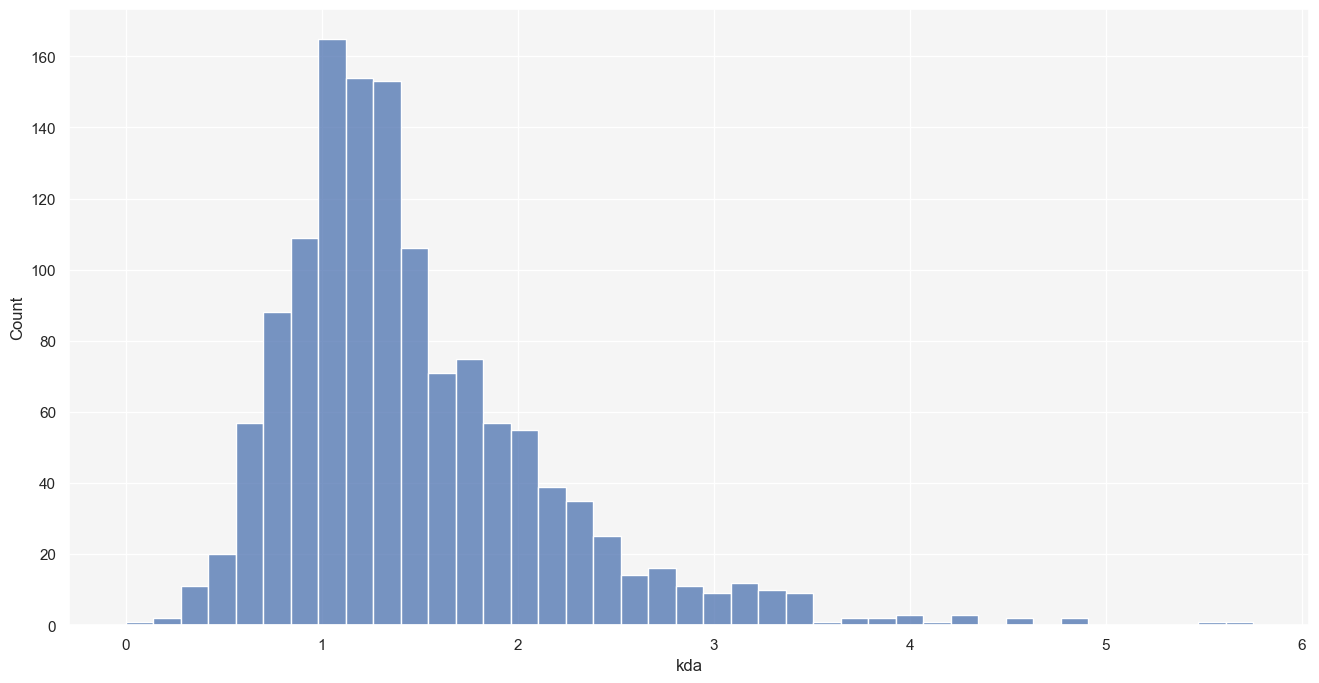

In [9]:
give_hist("kda")

#### Headshot Percentage

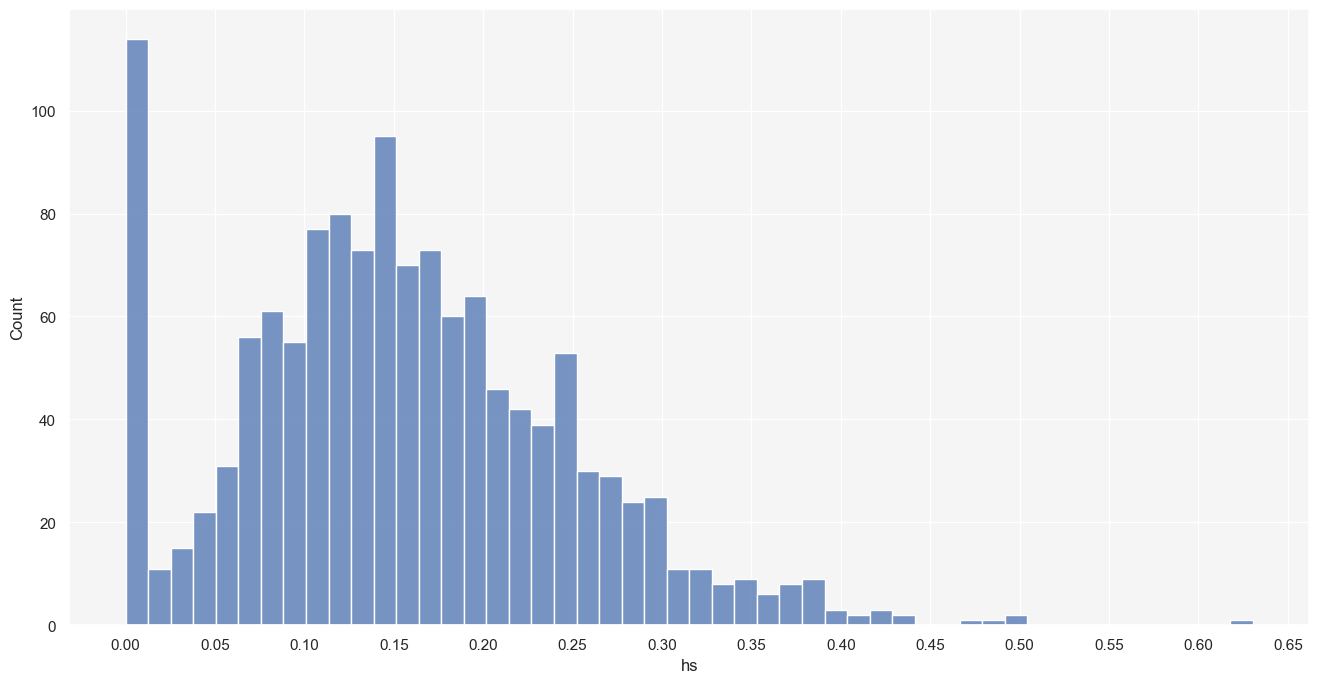

In [10]:
# Custom plot since hs is mostly in the lower fractions
sns.set(rc = {"figure.figsize": (16, 8), 'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})

sns.histplot(data = val_data, x = "hs", bins = 50)

plt.xticks(np.arange(0,0.7,0.05))
plt.show()

# High zero percent headshots since it was set to be zero for those who did not hit any shots; which is weird to begin with; might be better to remove those

#### Damage Delta

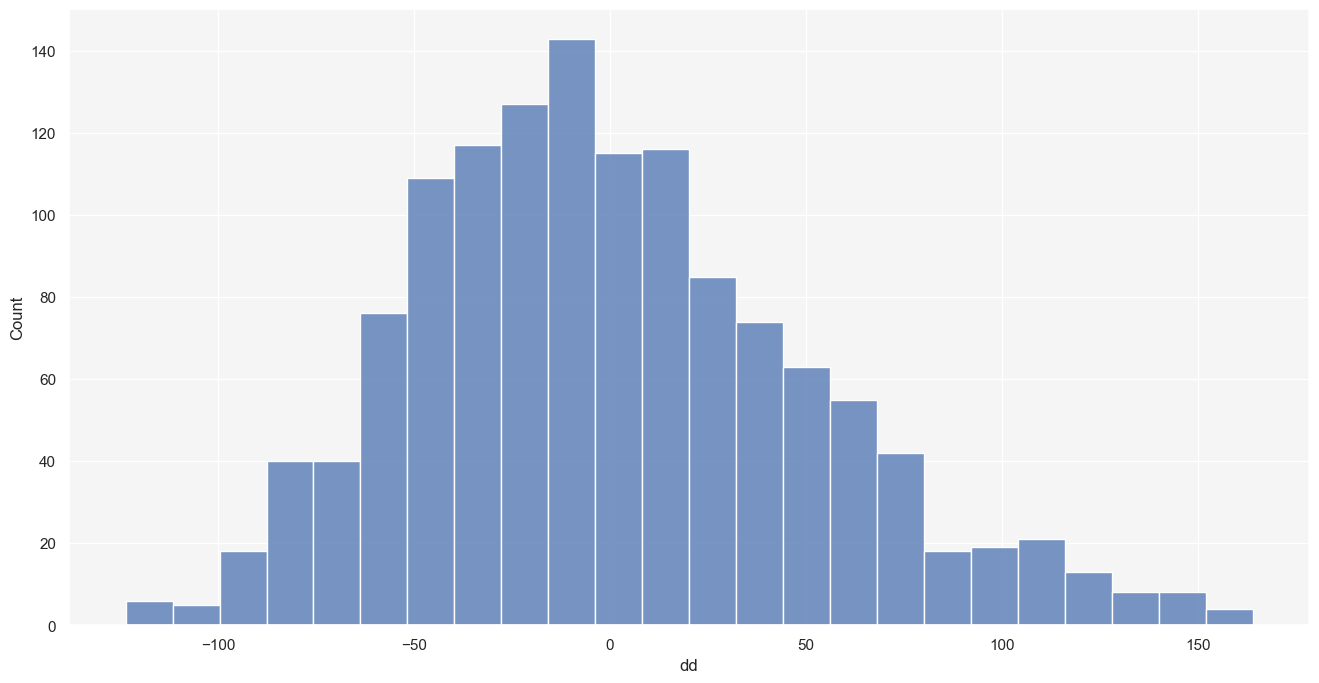

In [11]:
give_hist("dd")

#### KAST

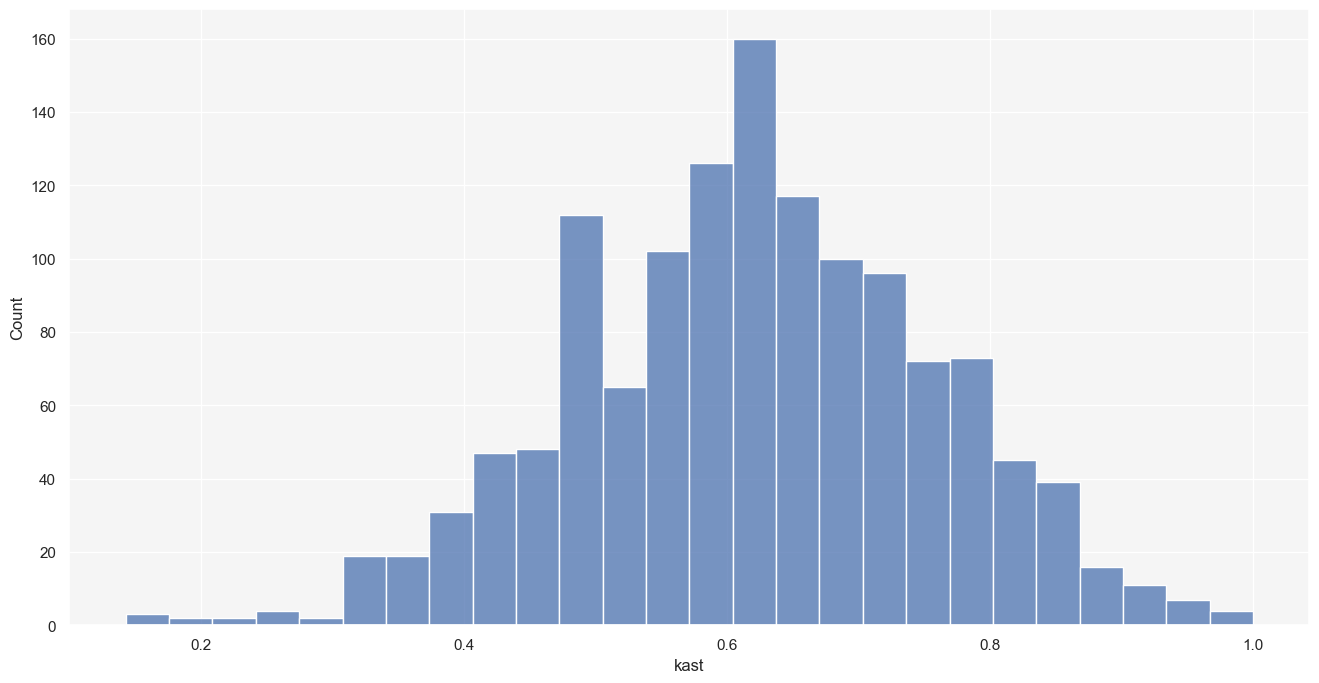

In [12]:
give_hist("kast")

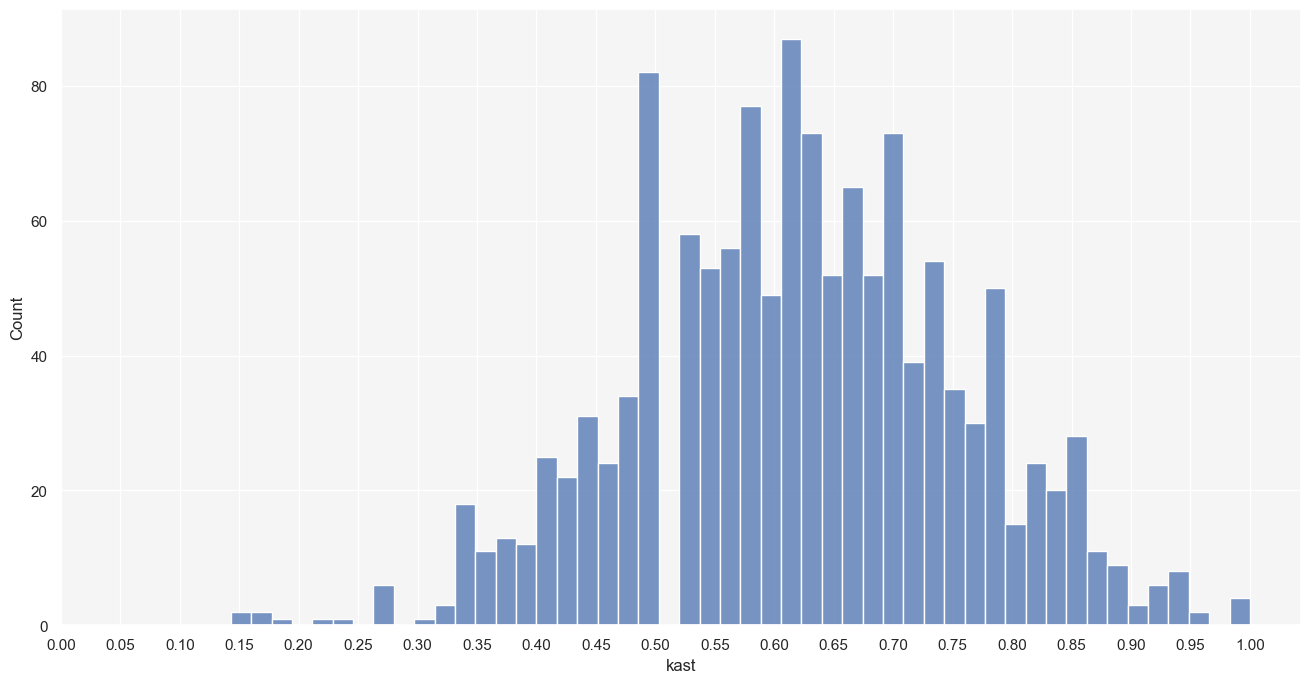

In [13]:
# Custom KAST plot since that was a problematic and complex veature to calculate

sns.set(rc = {"figure.figsize": (16, 8), 'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})

sns.histplot(data = val_data, x = "kast", bins = 50)

plt.xticks(np.asarray(range(21)) / 20)
plt.show()

# the spike in the .5 kast is very suspicious; a lot more suspicious when the number of bins is increased; valorant tracker has kast median at around 70%

#### Adjustments

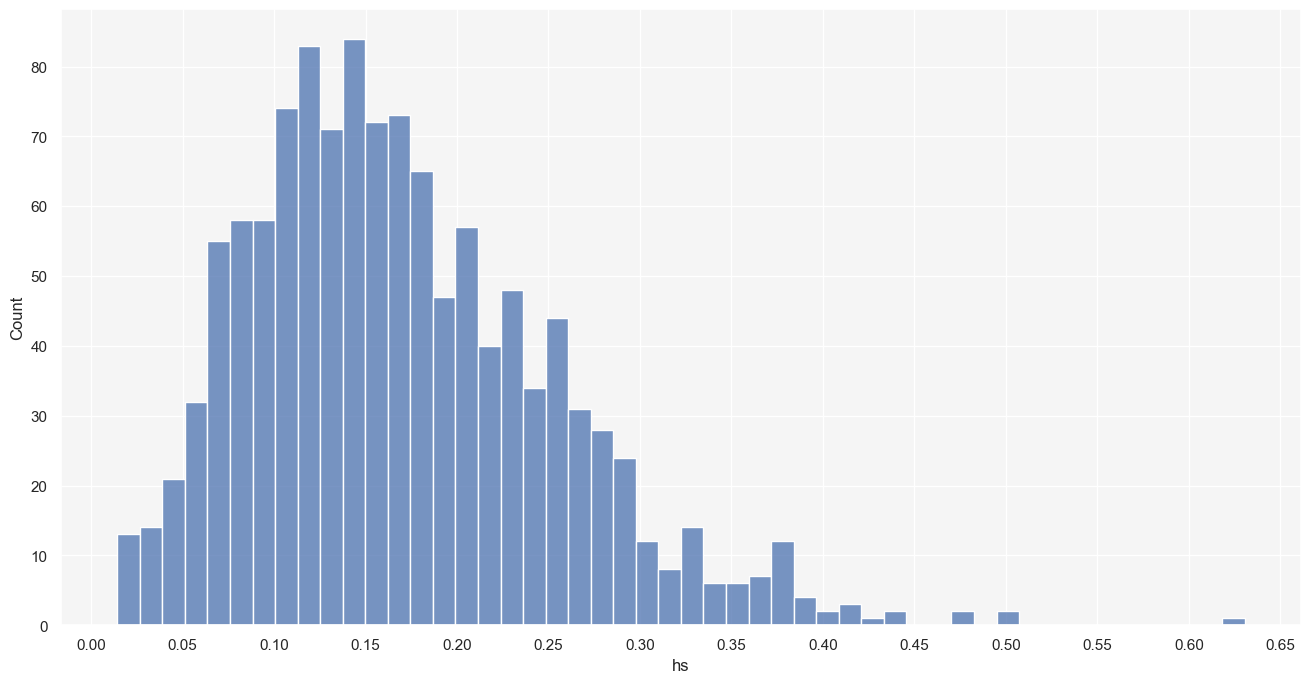

In [14]:
val_data = val_data[val_data["hs"] != 0]

# Custom plot since hs is mostly in the lower fractions
sns.set(rc = {"figure.figsize": (16, 8), 'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})

sns.histplot(data = val_data, x = "hs", bins = 50)

plt.xticks(np.arange(0,0.7,0.05))
plt.show()

##### Outlier Management

In [15]:
val_data.describe().columns[1:]

Index(['ability_usage_avg', 'acs', 'kda', 'hs', 'dd', 'kast'], dtype='object')

In [16]:
def give_std_limit(col):
    avg = val_data.describe().loc["mean",col]
    std = val_data.describe().loc["std",col]
    non_outlier = [avg - 3*std, avg + 3*std]

    return non_outlier

def give_iqr_limit(col):
    q1 = val_data.describe().loc["25%",col]
    q3 = val_data.describe().loc["75%",col]
    iqr = q3 - q1
    non_outlier = [q1 - 1.5*iqr, q3 + 1.5*iqr]
    
    return non_outlier

def remove_outliers(col, lim):
    lower_lim, upper_lim = lim
    return val_data[val_data[col].apply(lambda x: lower_lim < x < upper_lim)]

In [17]:
for column in val_data.describe().columns[1:]:
    print("\n",column)
    print("iqr",give_iqr_limit(column))
    print("std",give_std_limit(column))

#iqr seems to give the more strict limit for all, so those will be used


 ability_usage_avg
iqr [0.12918660287081352, 3.9952153110047846]
std [-0.10503559510720928, 4.301200265313707]

 acs
iqr [17.439440993788793, 406.7189440993789]
std [-2.702168674238777, 435.46181440578073]

 kda
iqr [-0.21875, 3.03125]
std [-0.6163264620218343, 3.5858830133867547]

 hs
iqr [-0.05498681006493507, 0.38312195616883116]
std [-0.08049631813279229, 0.4188625046425413]

 dd
iqr [-138.25716403162056, 137.46338932806324]
std [-151.5850993556953, 154.5275302065909]

 kast
iqr [0.25210084033613445, 0.9915966386554622]
std [0.2120770073784043, 1.0287048710622897]


In [18]:
for column in val_data.describe().columns[1:]:
    val_data = remove_outliers(column, give_iqr_limit(column))

<hr>

### EDA

#### Correlation Function

In [19]:
from scipy import stats 

def give_rank_corr(val_stat):
    figure, axes = plt.subplots(1, 2, sharex=True)
    
    sns.regplot(ax = axes[0], data = val_data, x = val_stat, y = "rank")
    sns.residplot(ax = axes[1], data = val_data, x = val_stat, y = "rank")

    axes[0].set_title("Correlation between "+val_stat+" and rank")
    axes[1].set_title("Residual Plot of "+val_stat+" and rank")

    plt.show()

    pearson_coef, pearson_p_value = stats.pearsonr(val_data[val_stat], val_data['rank'])
    spearman_coef, spearman_p_value = stats.spearmanr(val_data[val_stat], val_data['rank'])
    kendall_coef, kendall_p_value = stats.kendalltau(val_data[val_stat], val_data['rank'])
    
    print("The Pearson Correlation coefficient of",val_stat,"and rank is", pearson_coef, " with a P-value of P =", pearson_p_value) 
    print("The Spearman Correlation coefficient of",val_stat,"and rank is", spearman_coef, " with a P-value of P =", spearman_p_value) 
    print("The Kendall Tau coefficient of",val_stat,"and rank is", kendall_coef, " with a P-value of P =", kendall_p_value)  

#### Agent

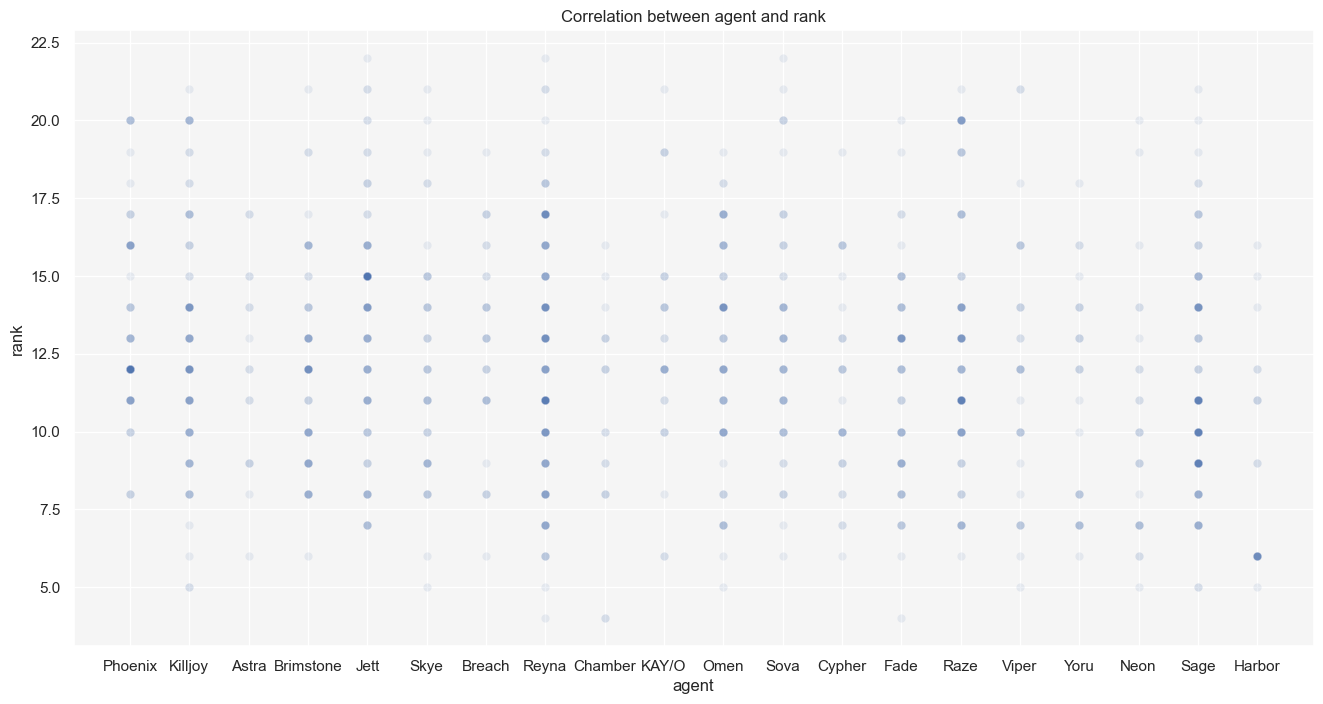

In [20]:
sns.scatterplot(data = val_data, x = "agent", y = "rank", alpha = 0.1)

plt.xlabel("agent")
plt.title("Correlation between "+"agent"+" and rank")
plt.show()

#### Win

<AxesSubplot: xlabel='outcome', ylabel='rank'>

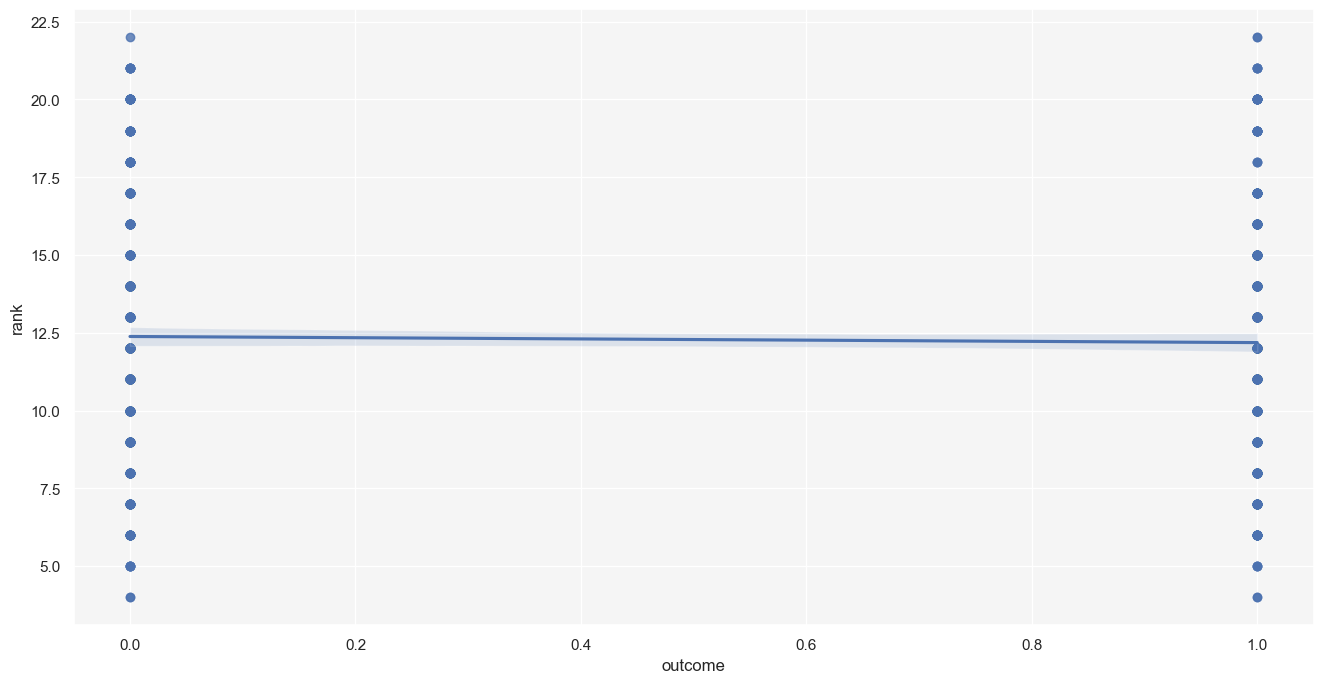

In [21]:
sns.regplot(data = val_data, x = "outcome", y = "rank")

# not reliable; high p value; win rate shouldnt matter much since matchmaking would make it around 50%

#### Ability Use

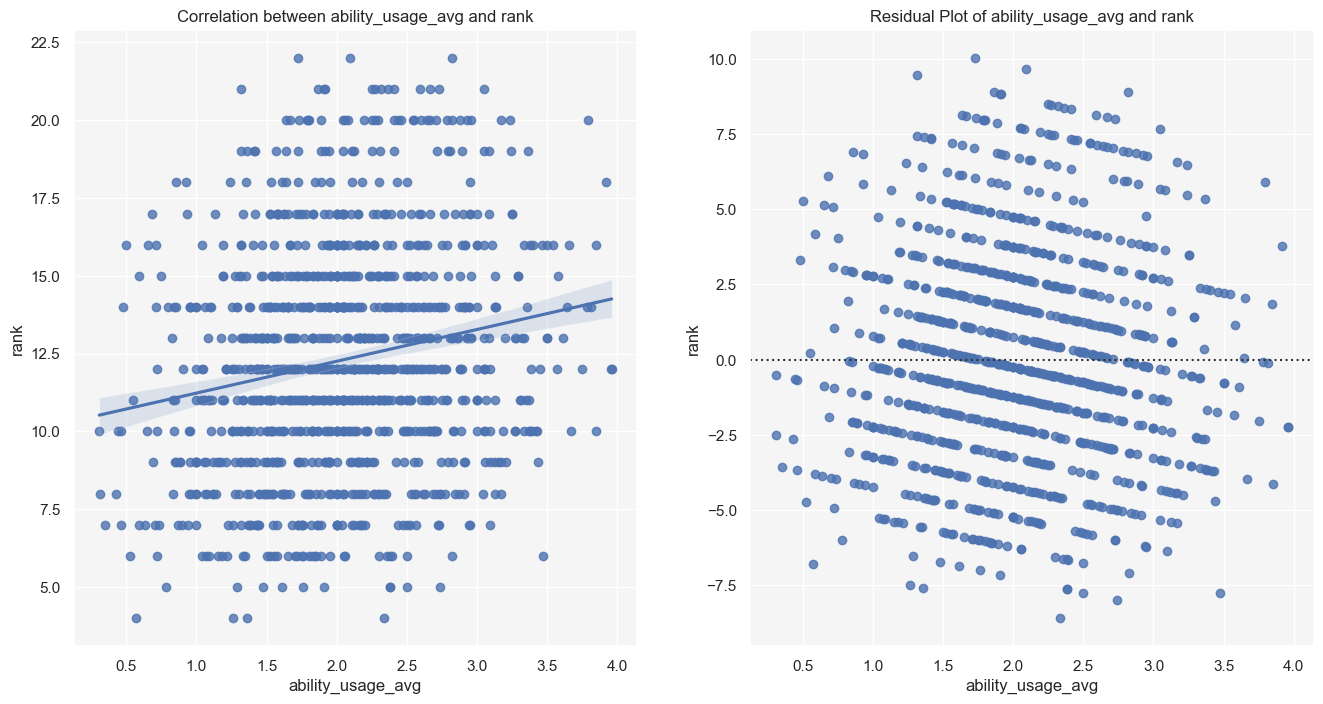

The Pearson Correlation coefficient of ability_usage_avg and rank is 0.18755645983001493  with a P-value of P = 4.440812592061646e-10
The Spearman Correlation coefficient of ability_usage_avg and rank is 0.17902701261586582  with a P-value of P = 2.6940215544764987e-09
The Kendall Tau coefficient of ability_usage_avg and rank is 0.12425791223477152  with a P-value of P = 3.4872245878205766e-09


In [22]:
give_rank_corr("ability_usage_avg")

#### ACS

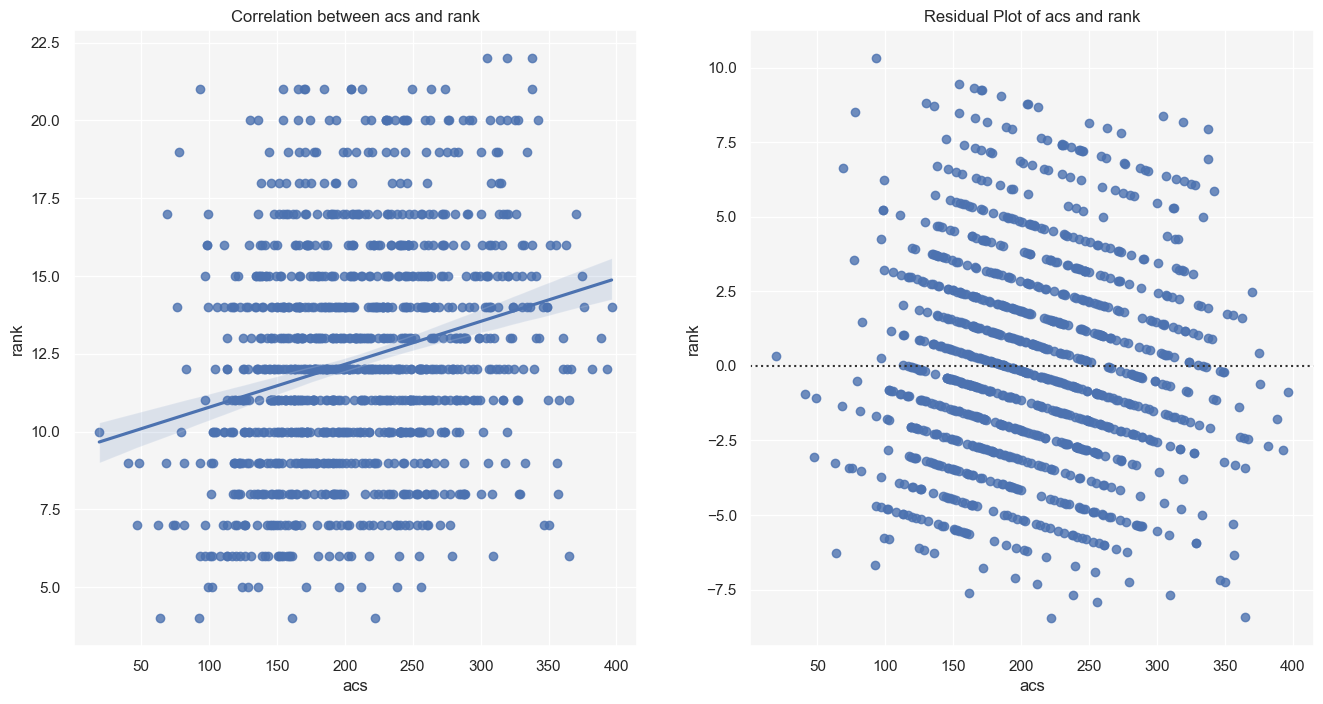

The Pearson Correlation coefficient of acs and rank is 0.24608678284700078  with a P-value of P = 1.7430480393642683e-16
The Spearman Correlation coefficient of acs and rank is 0.2466888094881351  with a P-value of P = 1.4646310146944318e-16
The Kendall Tau coefficient of acs and rank is 0.17342296477483987  with a P-value of P = 1.4498279436307344e-16


In [23]:
give_rank_corr("acs")

#### KDA

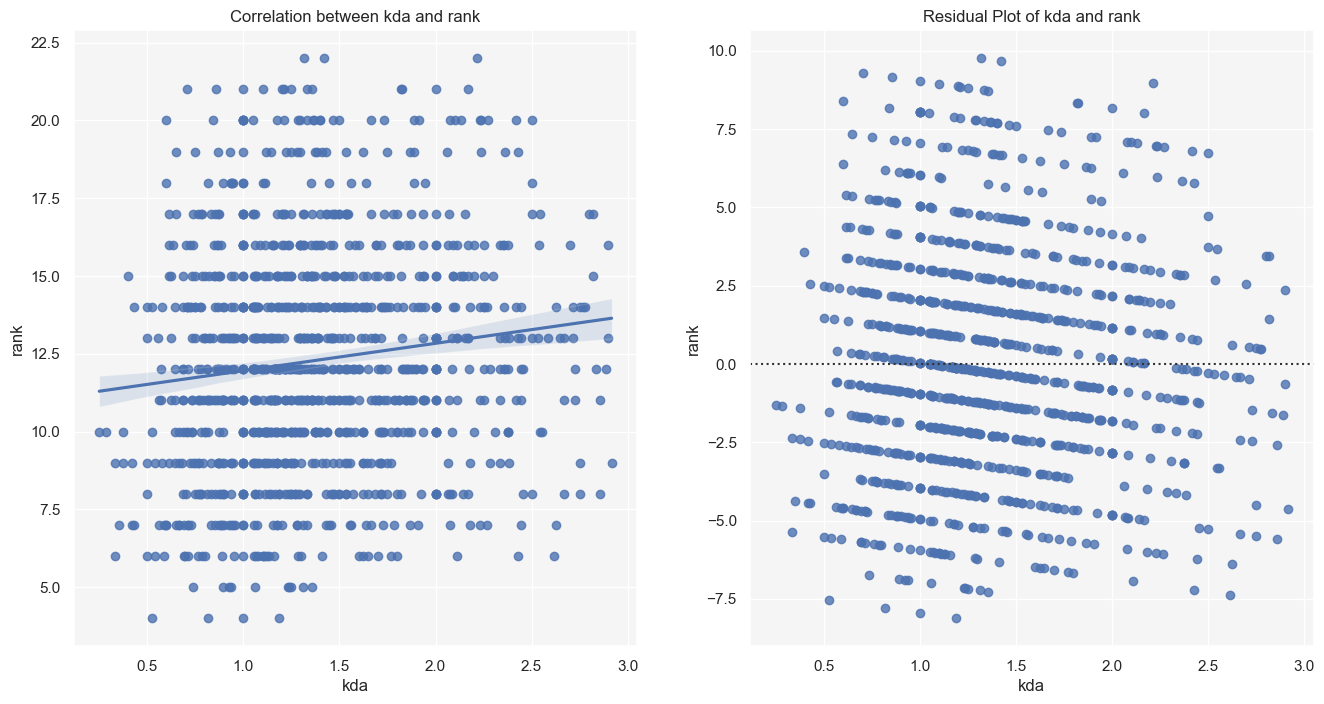

The Pearson Correlation coefficient of kda and rank is 0.1269639034613501  with a P-value of P = 2.645524228774378e-05
The Spearman Correlation coefficient of kda and rank is 0.13313366786145078  with a P-value of P = 1.0432888567622155e-05
The Kendall Tau coefficient of kda and rank is 0.09308159792981106  with a P-value of P = 9.984521176866349e-06


In [24]:
give_rank_corr("kda")

#### HS

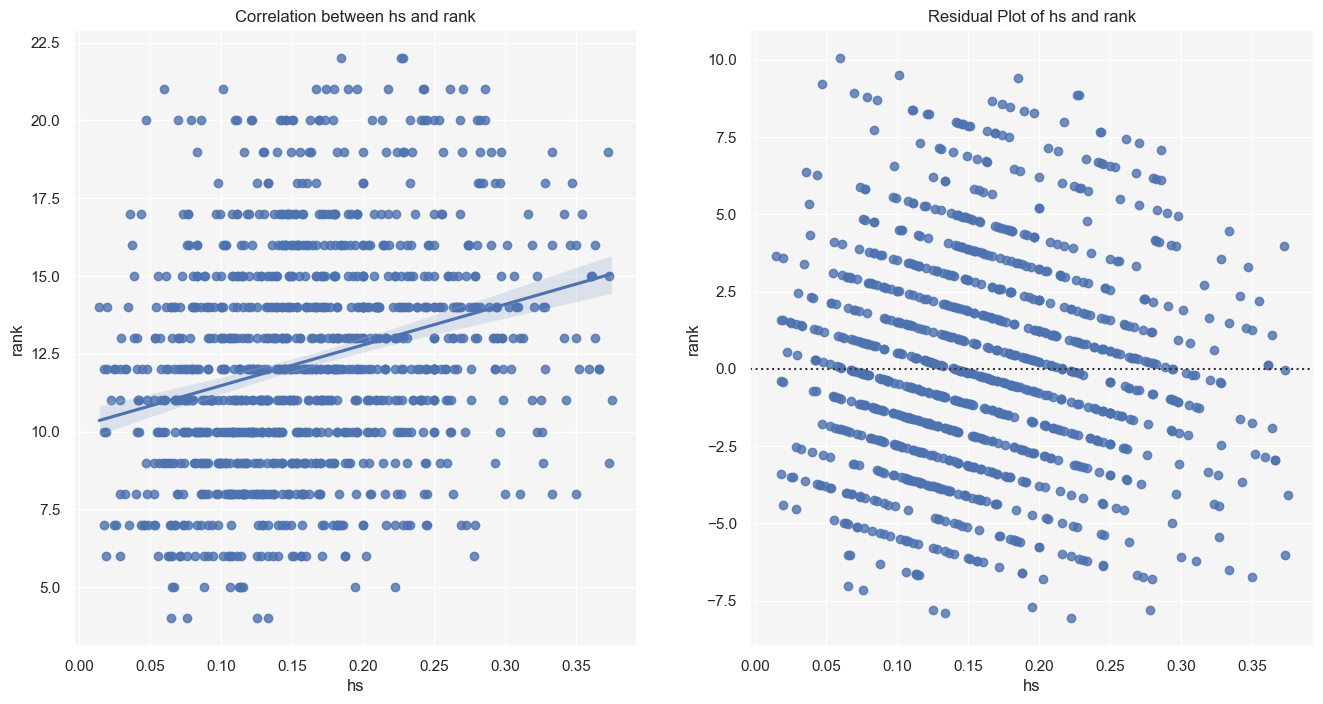

The Pearson Correlation coefficient of hs and rank is 0.26879741841900656  with a P-value of P = 1.768187738310094e-19
The Spearman Correlation coefficient of hs and rank is 0.2860791609316367  with a P-value of P = 5.87053031788084e-22
The Kendall Tau coefficient of hs and rank is 0.19724075495991913  with a P-value of P = 6.623183501693822e-21


In [25]:
give_rank_corr("hs")

#### DD

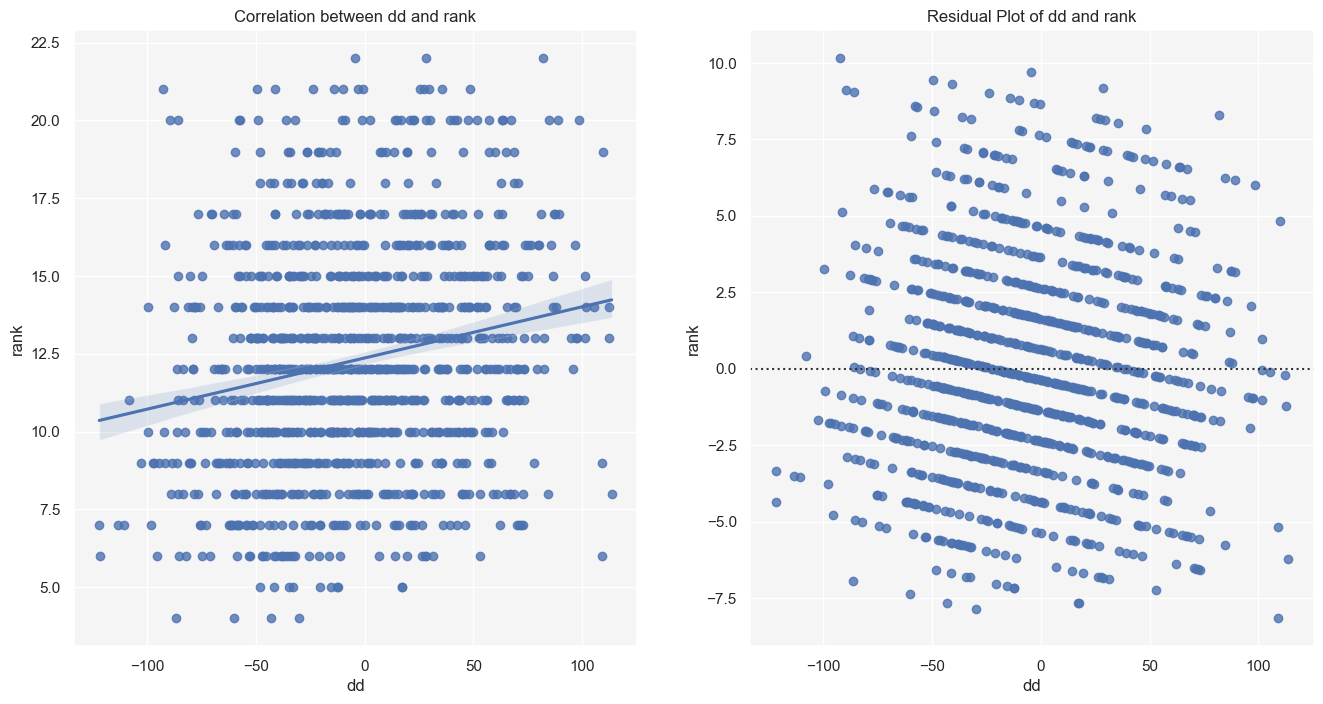

The Pearson Correlation coefficient of dd and rank is 0.2000026877558496  with a P-value of P = 2.7399717165845886e-11
The Spearman Correlation coefficient of dd and rank is 0.1988463000558769  with a P-value of P = 3.5771332937949644e-11
The Kendall Tau coefficient of dd and rank is 0.13942728749773795  with a P-value of P = 3.1105503938663296e-11


In [26]:
give_rank_corr("dd")

#### KAST

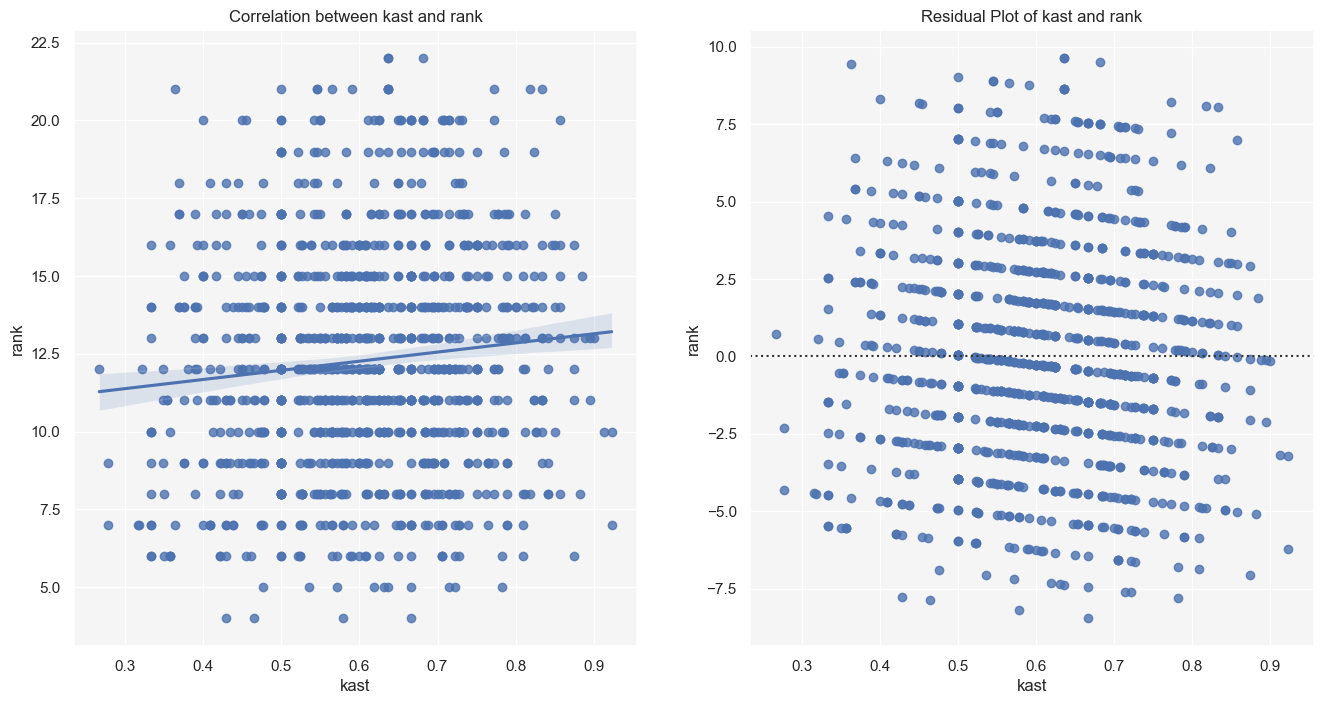

The Pearson Correlation coefficient of kast and rank is 0.10007957358893292  with a P-value of P = 0.0009425410949199448
The Spearman Correlation coefficient of kast and rank is 0.09769100915926839  with a P-value of P = 0.001247355712112536
The Kendall Tau coefficient of kast and rank is 0.06875930622825724  with a P-value of P = 0.0011672112136299983


In [27]:
give_rank_corr("kast")

<hr>

### Modeling

In [48]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import cross_val_score

In [30]:
x = val_data.drop(["rank", "agent"], axis = 1)
labels = x.columns
y = val_data["rank"].to_numpy()

# Normlize data set; different features have different ranges
x = preprocessing.StandardScaler().fit(x).transform(x)

# Split data set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [59]:
dc = DummyClassifier()
dc.fit(x,y)

print("accuracy: ", dc.score(x, y))
print("cv accuracy: ", cross_val_score(dc, x, y, cv = 4))

accuracy:  0.11937557392102846
cv accuracy:  [0.12087912 0.11764706 0.11764706 0.12132353]


C:\Users\Binaryxx Sune\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(


In [32]:
dc = DummyClassifier()
dc.fit(x_train,y_train)

print("accuracy: ", dc.score(x_train, y_train))
print("test accuracy: ", dc.score(x_test, y_test))

accuracy:  0.11286089238845144
test accuracy:  0.1345565749235474


In [58]:
lr = LinearRegression()
lr.fit(x_train,y_train)

print('Intercept: ',lr.intercept_,'\n Coefficients: ', lr.coef_, "\n Labels", labels) 
print("accuracy: ", lr.score(x_train, y_train))
print("test accuracy: ", lr.score(x_test, y_test))
print("cv accuracy: ", cross_val_score(lr, x, y, cv = 4))

Intercept:  12.289158107591403 
 Coefficients:  [-0.14075632  0.6143547   0.78722729 -0.34145007  0.81500121 -0.00948439
  0.03027516] 
 Labels Index(['outcome', 'ability_usage_avg', 'acs', 'kda', 'hs', 'dd', 'kast'], dtype='object')
accuracy:  0.13691116065612918
test accuracy:  0.1307395162356928
cv accuracy:  [ 0.14276716 -0.09377439  0.08098319 -0.15286404]


In [46]:
ord_mod = OrderedModel(y_train, x_train, distr = "probit")
ord_res = ord_mod.fit(method = "bfgs")
ord_res.summary()

Optimization terminated successfully.
         Current function value: 2.594799
         Iterations: 52
         Function evaluations: 54
         Gradient evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -1977.2
Model:                   OrderedModel   AIC:                             4004.
Method:            Maximum Likelihood   BIC:                             4120.
Date:                Wed, 15 Feb 2023                                         
Time:                        17:27:07                                         
No. Observations:                 762                                         
Df Residuals:                     737                                         
Df Model:                          25                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0417      0.047     -0.878      0.380      -0.135       0.051
x2             0.1853      0.039      4.714      0.000       0.108       0.262
x3             0.2541      0.069      3.663      0.000       0.118       0.390
x4            -0.0951      0.079     -1.211      0.226      -0.249       0.059
x5             0.2488      0.038      6.547      0.000       0.174       0.323
x6            -0.0204      0.088     -0.231      0.817      -0.194       0.153
x7             0.0053      0.057      0.092      0.927      -0.107       0.118
4/5           -2.7781      0.187    -14.892      0.000      -3.144      -2.412
5/6           -0.8091      0.349     -2.317      0.020      -1.493      -0.125
6/7           -0.6666      0.197     -3.382      0.001      -1.053      -0.280
7/8           -0.9350      0.159     -5.897      0.000      -1.246      -0.624
8/9           -1.0853      0.137     -7.906      0.000      -1.354      -0.816
9/10          -1.3573      0.138     -9.826      0.000      -1.628      -1.087
10/11         -1.1042      0.109    -10.122      0.000      -1.318      -0.890
11/12         -1.1390      0.103    -11.049      0.000      -1.341      -0.937
12/13         -1.1742      0.102    -11.519      0.000      -1.374      -0.974
13/14         -1.2844      0.109    -11.780      0.000      -1.498      -1.071
14/15         -1.2076      0.110    -11.026      0.000      -1.422      -0.993
15/16         -1.3742      0.130    -10.553      0.000      -1.629      -1.119
16/17         -1.3308      0.141     -9.428      0.000      -1.607      -1.054
17/18         -1.1945      0.153     -7.792      0.000      -1.495      -0.894
18/19         -2.0810      0.283     -7.353      0.000      -2.636      -1.526
19/20         -1.4728      0.235     -6.263      0.000      -1.934      -1.012
20/21         -0.7130      0.217     -3.281      0.001      -1.139      -0.287
21/22         -0.4826      0.362     -1.333      0.182      -1.192       0.227
==============================================================================
"""

#### Conclusion

The stats captured do not offer a way to accurately predict a person's rank, which correlates to the person's ability to competently play the game

Next Steps:  
The collected data is very limited and skewed that the reliability of the conclusion is questionable; the accuracy of the stats collected may also be not that reliable since there were instances where a number of players had questionable stats (0% accuracy) given that the matches are ranked matches (there may be some instances of an early surrender but it should not be as large as observed)